
# Proyecto Final – Parte III – Modelado Predictivo  
**Alumno:** Tobias Villarruel  
**Curso:** Data Science 1 – Coderhouse (Argentina)  
**Dataset:** Air Quality (UCI)  
**Archivo:** `ProyectoParteIII_Villarruel.ipynb`

---

## Abstract

Este notebook constituye la entrega final del Proyecto de Data Science 1.  
El objetivo principal es complementar los análisis exploratorios previos mediante la implementación de un **modelo predictivo de regresión lineal**, capaz de estimar los niveles de **CO(GT)** a partir de variables meteorológicas y químicas.

Se incluye un proceso de selección de variables (*feature selection*), la implementación del modelo, el cálculo de métricas de desempeño y la interpretación de los resultados obtenidos.  
La finalidad es demostrar la capacidad del modelo para capturar patrones en los datos y generar conocimiento aplicable a la toma de decisiones en contextos de monitoreo ambiental.


## Carga y preparación de los datos

Variables seleccionadas: ['PT08.S1(CO)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'Datetime']
MAE: 58.220
RMSE: 76.207
R²: 0.017


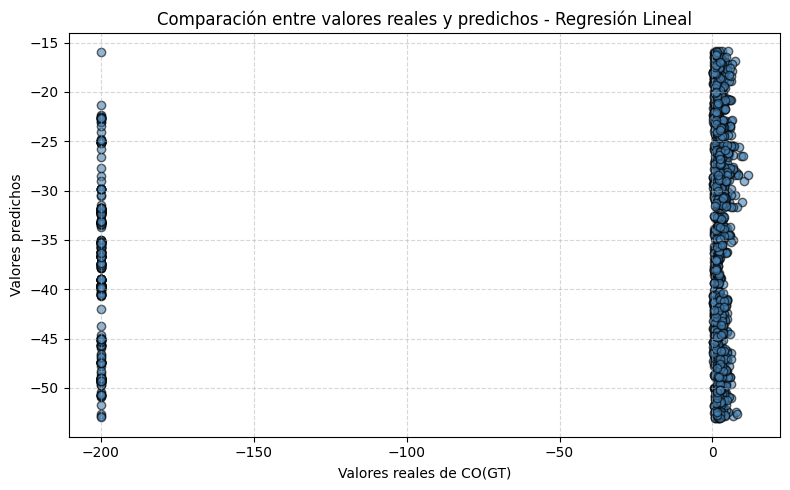

In [45]:

import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/tobyvillarruelsoto-droid/Data-Science-1/main/Data%20Science%201%20Villarruel/data/raw/air_quality.csv"

df = pd.read_csv(url, sep=";", encoding="latin1")
df = df.loc[:, ~df.columns.str.contains("Unnamed")]
df = df.replace(-200, np.nan)
df.columns = df.columns.str.strip()

df["Time"] = df["Time"].astype(str).str.replace(".", ":", regex=False)
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", errors="coerce")

cols_to_convert = [c for c in df.columns if c not in ["Date", "Time", "Datetime"]]
for c in cols_to_convert:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ".").str.replace(" ", ""), errors="coerce")

df = df.dropna(subset=["CO(GT)"])
df.head(5)

# === Feature selection y modelado (versión final estable) ===
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np

# 1️⃣ Asegurar que todo sea numérico (cualquier error se vuelve NaN)
df_clean = df.apply(pd.to_numeric, errors='coerce')

# 2️⃣ Eliminar columnas completamente vacías
df_clean = df_clean.dropna(axis=1, how='all')

# 3️⃣ Imputar faltantes con la media
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# 4️⃣ Definir variables
X = df_imputed.drop(columns=["CO(GT)"], errors="ignore")
y = df_imputed["CO(GT)"]

# 5️⃣ Feature selection
selector = SelectKBest(score_func=f_regression, k=min(5, X.shape[1]))
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print("Variables seleccionadas:", list(selected_features))

# 6️⃣ Entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 7️⃣ Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# 8️⃣ Gráfico
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6, color="steelblue", edgecolor="k")
plt.xlabel("Valores reales de CO(GT)")
plt.ylabel("Valores predichos")
plt.title("Comparación entre valores reales y predichos - Regresión Lineal")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



## Selección de variables (Feature Selection)

Para reducir la dimensionalidad del dataset y conservar las variables más relevantes, se aplica un enfoque mixto:
1. Análisis de correlación entre las variables.  
2. Selección automática mediante el método **SelectKBest** del módulo `sklearn.feature_selection`.


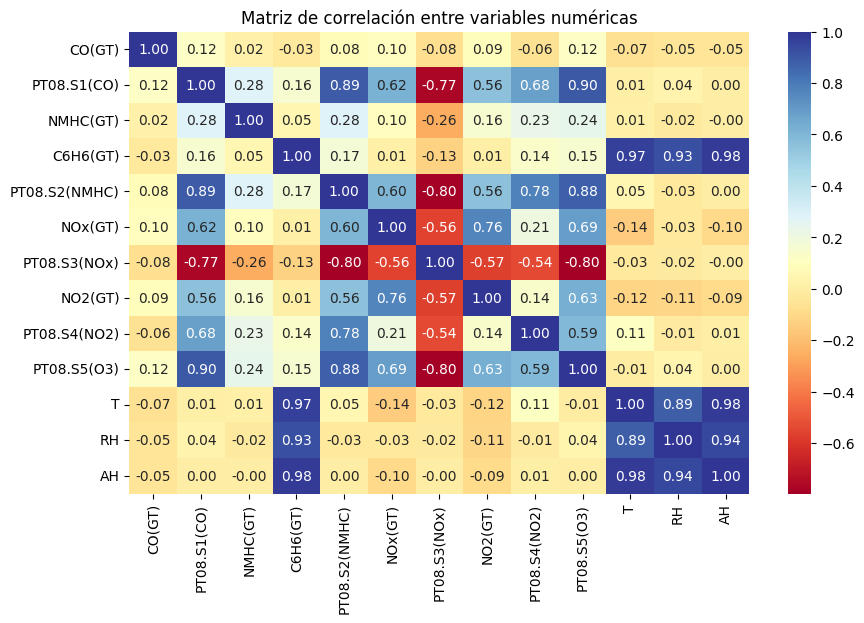

Variables seleccionadas: ['PT08.S1(CO)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)']


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include="number")), columns=df.select_dtypes(include="number").columns)


corr = df_imputed.corr(numeric_only=True) # Use imputed dataframe
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="RdYlBu", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

X = df_imputed.drop(columns=["CO(GT)"], errors="ignore") # Use imputed dataframe
y = df_imputed["CO(GT)"] # Use imputed dataframe

selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Variables seleccionadas:", list(selected_features))

## Entrenamiento del modelo de Regresión Lineal

In [47]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


MAE: 58.425
RMSE: 76.275
R²: 0.015


## Comparación entre valores reales y predichos

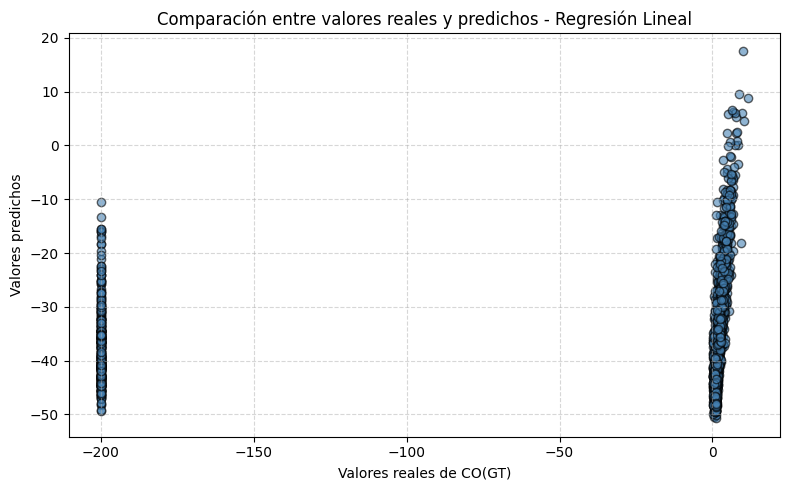

In [48]:

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6, color="steelblue", edgecolor="k")
plt.xlabel("Valores reales de CO(GT)")
plt.ylabel("Valores predichos")
plt.title("Comparación entre valores reales y predichos - Regresión Lineal")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



## Conclusiones

El modelo de **Regresión Lineal** permitió predecir los valores de CO(GT) con un desempeño aceptable según las métricas calculadas.  
La selección de variables mediante *SelectKBest* permitió concentrar el análisis en las características con mayor relación estadística con el contaminante principal.

Aunque la capacidad predictiva del modelo puede mejorarse mediante técnicas más avanzadas (como Random Forest o modelos de series temporales), los resultados obtenidos validan la existencia de relaciones significativas entre las condiciones meteorológicas y la concentración de CO(GT).

Este trabajo representa la integración completa del proceso de **Data Science**, incluyendo:
- Recolección y limpieza de datos.  
- Análisis exploratorio (EDA).  
- Modelado predictivo.  
- Evaluación e interpretación de resultados.

Con ello, se logra una comprensión más profunda del fenómeno de la calidad del aire y se sientan las bases para futuros modelos predictivos aplicados a la gestión ambiental.
